08/11-2025

### Project 16
Predicting Isoform Expression from Gene-Level Profiles using Representation Learning
The central dogma of molecular biology states that DNA is transcribed into RNA, which is then translated into proteins. While a one-gene–one-protein model is often assumed, the process of alternative splicing at the RNA level can result in multiple protein isoforms with distinct biological functions from the same gene. Hence gene expression data only provides a coarse-grained view of transcriptional activity and in many cases disease and cell-type-specific behaviour is determined by which isoforms are expressed. However, while gene expression data is abundant, measuring isoform expression is technically challenging and costly, especially in single-cell experiments. Therefore, the goal of this project is to develop a computational method for accurately predicting isoform expression from gene expression alone. If successful, this would unlock isoform-level insights for millions of existing RNA-seq samples. <br>
Outline for the project: <br>
<br>
Train a simple feed-forward neural network to predict isoform expression from gene expression data.
Compare raw gene expression input with feature representations derived from PCA, Variational Autoencoders (VAEs) and pre-trained transformer-based models, such as scGPT, Geneformer, BulkFormer or scLong <br>
Experiment with architectures (e.g., MLP, residual MLP, or shallow transformer) <br>
Evaluate predictive performance of the different representations and/or model architectures <br>
Other ideas are also very welcome <br>
This project will be supervised by TA Mikkel Niklas Rasmussen (minra@dtu.dk).

***Let's get this bread***

Note: Use the Python 3.9.21 in the .venv, for now. It should automatically be suggested by the server. 

In [1]:
#This notebook was initially designed to run in the HPC cluster, and not inside the cloned "DeepIsoQ" repo folder in the HPC cluster, 
#So we need to start out by adjusting the folder location.  

import os

# Get the current working directory
current_dir = os.getcwd()

# Extract the directory name
dir_name = os.path.basename(current_dir)

# Check if the directory name is "DeepIsoQ"
if dir_name == "DeepIsoQ":
    # Move out of the current directory
    os.chdir("..")
    print(f"Moved out of {dir_name}. Current directory is now: {os.getcwd()}")
else:
    print(f"Current directory is not 'DeepIsoQ'. Current directory is: {current_dir}")


Moved out of DeepIsoQ. Current directory is now: /zhome/72/4/168624


In [3]:
first_time_running = False #If you are reading this, you should change this to True, and False afterwards. 

In [4]:
#Making symbolic link to the data folder: 

if first_time_running:
    !ln -s /work3/s193518/scIsoPred/data .

In [5]:
#Installing relevant packages

if first_time_running:
    !pip install scanpy
    !pip install torch torchvision torchaudio

In [6]:
import torch
print(torch.__version__)
print("CUDA available:", torch.cuda.is_available()) #Preferably, CUDA should be available, so we can use the GPU! 

2.8.0+cu128
CUDA available: False


In [7]:
# #Checking the dimensions of the expression matrices for the 2 datasets:
# #Commented out, due to long run-time. 

# import scanpy as sc

# adata_genes = sc.read_h5ad('data/bulk_processed_genes.h5ad', backed='r')
# adata_transcripts = sc.read_h5ad('data/bulk_processed_transcripts.h5ad', backed='r')

# print("Genes shape:", adata_genes.shape)
# print("Transcripts shape:", adata_transcripts.shape)

**Results:** <br>

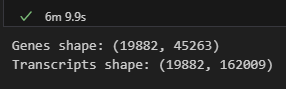

In [9]:

if first_time_running:
    import scanpy as sc
    adata_genes = sc.read_h5ad('data/bulk_processed_genes.h5ad', backed='r')

    gene_to_transcript_dict = adata_genes.uns["gene_to_transcripts"].copy()

    #Save the dict data in a binary file:
    import pickle

    with open("gene_to_transcript_dict.pkl", "wb") as f:
        pickle.dump(gene_to_transcript_dict, f)

Run time: 3 minutes and 25 seconds. 

In [10]:
#Load the dict, if you have already previously made the file: 

if first_time_running == False:

    import pickle

    with open("gene_to_transcript_dict.pkl", "rb") as f:
        gene_to_transcript_dict = pickle.load(f)

In [11]:
gene_to_transcript_dict["A1BG"]

array(['ENST00000596924', 'ENST00000595014', 'ENST00000598345',
       'ENST00000600966'], dtype=object)

### Difference between gene and transcript expression files: <br> 

**Genes**: There are 45,263 expressed genes (total from all isoforms)<br>
**Transcripts**: There are 162,009 expressed transcripts (the differently spliced isoforms). I.e. abundance of a specific spliced isoform. 

Note: At the current stage, I haven't figured out how to map a given gene to its corresponding isoforms.<br>
But strictly speaking, for now, this is more of a nice-to-have feature than a need-to-have feature. <br>
Since, ultimately we just need to translate n_sample x n_genes dimensional data into n_samples x n_isoform_transcripts dimensional data. 

### **Only loading a subset of the h5ad files, to not deal with memory issues:**

In [14]:

if first_time_running:

    import h5py
    import numpy as np
    from scipy.sparse import csr_matrix, save_npz
    import scanpy as sc

    print("Creating small subset of data for testing...")

    # Try to open with scanpy first for the subset
    try:
        print("\nAttempt 1: Using scanpy backed mode...")
        adata_genes = sc.read_h5ad("data/bulk_processed_genes.h5ad", backed='r')
        
        # Take just the first 100 samples and ALL genes (our model would be somewhat useless, if we only cover a fraction of all the genes/ transcripts)
        n_samples = min(100, adata_genes.n_obs)
        n_genes = adata_genes.n_vars #45,263

        gene_dimensions = (n_samples, n_genes)
        
        print(f"Extracting subset: {n_samples} samples × {n_genes} genes")
        
        # Extract small chunks at a time
        chunk_size = 100
        chunks = []
        
        for i in range(0, n_samples, chunk_size):
            end = min(i + chunk_size, n_samples)
            print(f"  Reading samples {i}-{end}...")
            chunk = adata_genes[i:end, :n_genes].to_memory()
            chunks.append(chunk)
        
        # Concatenate chunks
        import anndata as ad
        adata_subset = ad.concat(chunks, axis=0)
        
        print(f"\nSaving subset...")
        adata_subset.write('bulk_genes_subset.h5ad')
        print(f"✓ Saved: bulk_genes_subset.h5ad (shape: {adata_subset.shape})")
        
    except Exception as e:
        print(f"Scanpy method failed: {e}")
        print("\nAttempt 2: Using h5py directly...")
        
        # Open with h5py
        f = h5py.File("data/bulk_processed_genes.h5ad", 'r')
        
        # Read metadata
        obs_names = f['obs']['_index'][:]
        if isinstance(obs_names[0], bytes):
            obs_names = [x.decode('utf-8') for x in obs_names]
        
        var_names = f['var']['_index'][:]
        if isinstance(var_names[0], bytes):
            var_names = [x.decode('utf-8') for x in var_names]
        
        # Take subset
        n_samples = min(1000, len(obs_names))
        n_genes = len(var_names) #Pick all the genes. 
        
        print(f"Extracting subset: {n_samples} samples × {n_genes} genes")
        
        # Read indptr to know the sparse structure
        indptr = f['X']['indptr'][:n_samples + 1]
        
        # Build subset sparse matrix
        new_data = []
        new_indices = []
        new_indptr = [0]
        
        for i in range(n_samples):
            if i % 100 == 0:
                print(f"  Processing sample {i}/{n_samples}...")
            
            start = indptr[i]
            end = indptr[i + 1]
            
            row_indices = f['X']['indices'][start:end]
            row_data = f['X']['data'][start:end]
            
            # Keep only genes in our subset
            mask = row_indices < n_genes
            new_indices.extend(row_indices[mask])
            new_data.extend(row_data[mask])
            new_indptr.append(len(new_data))
        
        # Create sparse matrix
        X_subset = csr_matrix(
            (new_data, new_indices, new_indptr),
            shape=(n_samples, n_genes)
        )
        
        # Save as npz
        save_npz('bulk_genes_subset.npz', X_subset) #Note: Doesn't seem to be working. 
        
        # Save IDs
        with open('subset_sample_ids.txt', 'w') as file:
            file.write('\n'.join(obs_names[:n_samples]))
        
        with open('subset_gene_ids.txt', 'w') as file:
            file.write('\n'.join(var_names[:n_genes]))
        
        f.close()
        
        print(f"\n✓ Saved subset as:")
        print(f"  - bulk_genes_subset.npz (shape: {X_subset.shape})")
        print(f"  - subset_sample_ids.txt")
        print(f"  - subset_gene_ids.txt")

    ##############################################

    # Do the same for transcripts
    print("\n" + "="*60)
    print("Processing transcripts dataset...")
    print("="*60)

    try:
        print("\nAttempt 1: Using scanpy backed mode...")
        adata_transcripts = sc.read_h5ad("data/bulk_processed_transcripts.h5ad", backed='r')
        
        # Take just the first 100 samples and ALL genes (our model would be somewhat useless, if we only cover a fraction of all the genes/ transcripts)
        n_samples = min(100, adata_transcripts.n_obs)
        n_transcripts = adata_transcripts.n_vars #162,009
        
        transcript_dimensions = (n_samples, n_transcripts)
        
        print(f"Extracting subset: {n_samples} samples × {n_transcripts} transcripts")
        
        chunk_size = 100
        chunks = []
        
        for i in range(0, n_samples, chunk_size):
            end = min(i + chunk_size, n_samples)
            print(f"  Reading samples {i}-{end}...")
            chunk = adata_transcripts[i:end, :n_transcripts].to_memory()
            chunks.append(chunk)
        
        import anndata as ad
        adata_subset = ad.concat(chunks, axis=0)
        
        print(f"\nSaving subset...")
        adata_subset.write('bulk_transcripts_subset.h5ad')
        print(f"✓ Saved: bulk_transcripts_subset.h5ad (shape: {adata_subset.shape})")
        
    except Exception as e:
        print(f"Scanpy method failed: {e}")
        print("\nAttempt 2: Using h5py directly...")
        
        f = h5py.File("data/bulk_processed_transcripts.h5ad", 'r')
        
        obs_names = f['obs']['_index'][:]
        if isinstance(obs_names[0], bytes):
            obs_names = [x.decode('utf-8') for x in obs_names]
        
        var_names = f['var']['_index'][:]
        if isinstance(var_names[0], bytes):
            var_names = [x.decode('utf-8') for x in var_names]
        

        n_samples = min(1000, len(obs_names))
        n_transcripts = len(var_names) #Pick all the genes. 
        
        print(f"Extracting subset: {n_samples} samples × {n_transcripts} transcripts")
        
        indptr = f['X']['indptr'][:n_samples + 1]
        
        new_data = []
        new_indices = []
        new_indptr = [0]
        
        for i in range(n_samples):
            if i % 100 == 0:
                print(f"  Processing sample {i}/{n_samples}...")
            
            start = indptr[i]
            end = indptr[i + 1]
            
            row_indices = f['X']['indices'][start:end]
            row_data = f['X']['data'][start:end]
            
            mask = row_indices < n_transcripts
            new_indices.extend(row_indices[mask])
            new_data.extend(row_data[mask])
            new_indptr.append(len(new_data))
        
        X_subset = csr_matrix(
            (new_data, new_indices, new_indptr),
            shape=(n_samples, n_transcripts)
        )
        
        save_npz('bulk_transcripts_subset.npz', X_subset)
        
        with open('subset_transcript_ids.txt', 'w') as file:
            file.write('\n'.join(var_names[:n_transcripts]))
        
        f.close()
        
        print(f"\n✓ Saved subset as:")
        print(f"  - bulk_transcripts_subset.npz (shape: {X_subset.shape})")
        print(f"  - subset_transcript_ids.txt")

    ##########

    print("\n" + "="*60)
    print("DONE! You now have small subsets to work with:")
    print(f"  Genes: {gene_dimensions[0]} samples × {gene_dimensions[1]} genes")
    print(f"  Transcripts: {transcript_dimensions[0]} samples × {transcript_dimensions[1]} transcripts")
    print("="*60)
    

Run time: 6 minutes and 38 seconds. 

In [15]:
# If saved as .h5ad files: 
import scanpy as sc
adata_genes = sc.read_h5ad('bulk_genes_subset.h5ad')
adata_transcripts = sc.read_h5ad('bulk_transcripts_subset.h5ad')


In [16]:
#You can check some of the metadata using .obs. 
#We just do this to ensure that the order of the 
#gene and -transcript files are the same (otherwise, we would have to map them). 
adata_genes.obs.head(2)

,geo_accession,series_id,characteristics_ch1,extract_protocol_ch1,source_name_ch1,title,contact_city,contact_country,contact_institute,instrument_model,...,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,mt_outlier,n_counts,n_genes,leiden
GSM1019741,GSM1019741,"GSE41586,GSE41588","cell line: HT29,cell type: colon cancer,treatm...","Each monolayer was washed with PBS, scraped an...",HT29 treated with 10 Î¼M of 5-Aza,"HT29 at 10 Î¼M of 5-Aza, biological rep1",Stony Brook,USA,Stony Brook University BME,Illumina HiSeq 2000,...,2620719,18.870185,240636,1.732672,926,0.006668,False,13888147,38534,0
GSM1020212,GSM1020212,GSE41616,"cell type: corneal endothelial cells,age: 31y",RNA were extracted from those adult and fetal ...,corneal endothelial cells,adult CEC 33,Los Angeles,USA,UCLA,Illumina HiSeq 2000,...,8910388,15.738305,1845650,3.259948,2783,0.004916,False,56615931,36346,0


In [17]:
adata_transcripts.obs.head(2)

,geo_accession,series_id,characteristics_ch1,extract_protocol_ch1,source_name_ch1,title,contact_city,contact_country,contact_institute,instrument_model,...,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,total_counts_hb,pct_counts_hb,mt_outlier,n_counts,n_genes,leiden
GSM1019741,GSM1019741,"GSE41586,GSE41588","cell line: HT29,cell type: colon cancer,treatm...","Each monolayer was washed with PBS, scraped an...",HT29 treated with 10 Î¼M of 5-Aza,"HT29 at 10 Î¼M of 5-Aza, biological rep1",Stony Brook,USA,Stony Brook University BME,Illumina HiSeq 2000,...,2620719,18.870185,240636,1.732672,926,0.006668,False,13888147,38534,0
GSM1020212,GSM1020212,GSE41616,"cell type: corneal endothelial cells,age: 31y",RNA were extracted from those adult and fetal ...,corneal endothelial cells,adult CEC 33,Los Angeles,USA,UCLA,Illumina HiSeq 2000,...,8910388,15.738305,1845650,3.259948,2783,0.004916,False,56615931,36346,0


It is worth noting that the gene and transcript file is seemingly already sorted based on the same samples - so no mapping is required for samples. <br>
<br>
For gene --> transcript mapping, we can use the dict, 'gene_to_transcript_dict'. 

In [18]:
print(adata_genes.X.shape)
print(adata_genes.X[0].shape) #For any given sample, there are 45263 registered genes. 
print()
print(adata_transcripts.X.shape) #In h5ad format, the shape means (n_cells, n_genes or n_transcripts)
print(adata_transcripts.X[0].shape) #For any given sample, there are 162009 registered transcripts. 

(100, 45263)
(1, 45263)

(100, 162009)
(1, 162009)


In [19]:
adata_genes.var.head(3)

""
DDX11L1
WASH7P
FAM138A


In [20]:
adata_transcripts.var.head(3) #Note: You can't seemingly directly map genes to isoforms. 

""
transcript_id
ENST00000456328
ENST00000488147
ENST00000461467


**Exploring the .h5ad data:**

GENE DATA
Shape: (100, 45263)
  Samples (observations): 100
  Genes (variables): 45263

First 5 gene names:
['DDX11L1', 'WASH7P', 'FAM138A', 'OR4F5', 'ENSG00000238009']

First 5 sample IDs:
['GSM1019741', 'GSM1020212', 'GSM1041196', 'GSM1060226', 'GSM1060355']

Sparsity (amount of zeros): 40.99% zeros
Min value: 0.0000
Max value: 30187200.0000
Mean value: 822.7005
Median value: 2.0000


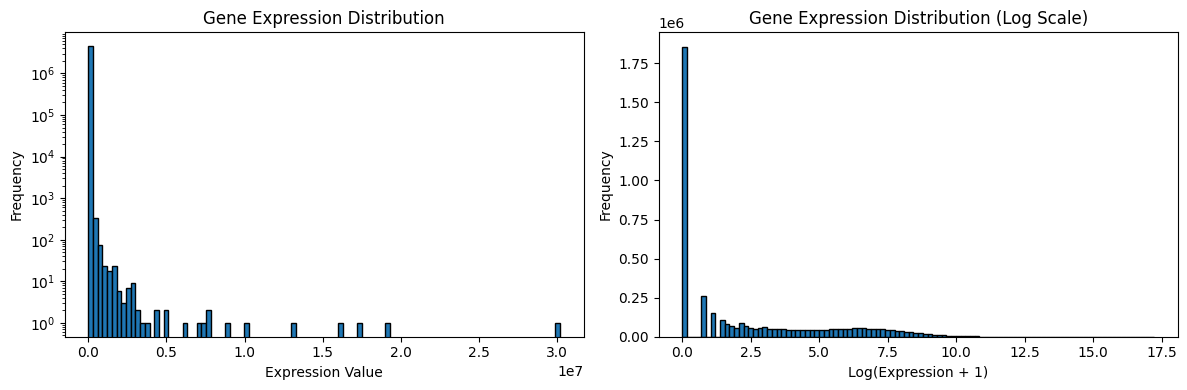


TRANSCRIPT DATA
Shape: (100, 162009)
  Samples (observations): 100
  Transcripts (variables): 162009

First 5 transcript names:
['ENST00000456328', 'ENST00000488147', 'ENST00000461467', 'ENST00000641515', 'ENST00000466430']

Sparsity (amount of zeros): 45.39% zeros
Min value: 0.0000
Max value: 30187200.0000
Mean value: 240.2806
Median value: 2.0000

METADATA
Gene metadata columns: []
Transcript metadata columns: []
Sample metadata columns: ['geo_accession', 'series_id', 'characteristics_ch1', 'extract_protocol_ch1', 'source_name_ch1', 'title', 'contact_city', 'contact_country', 'contact_institute', 'instrument_model', 'library_source', 'organism_ch1', 'platform_id', 'singlecellprobability', 'submission_date', 'taxid_ch1', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_

In [21]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Load the data
adata_genes = sc.read_h5ad('bulk_genes_subset.h5ad')
adata_transcripts = sc.read_h5ad('bulk_transcripts_subset.h5ad')

print("="*60)
print("GENE DATA")
print("="*60)
print(f"Shape: {adata_genes.shape}")
print(f"  Samples (observations): {adata_genes.n_obs}")
print(f"  Genes (variables): {adata_genes.n_vars}")
print(f"\nFirst 5 gene names:")
print(adata_genes.var_names[:5].tolist())
print(f"\nFirst 5 sample IDs:")
print(adata_genes.obs_names[:5].tolist())

# Check sparsity
X_genes = adata_genes.X
if hasattr(X_genes, 'toarray'):
    X_genes_dense = X_genes.toarray()
else:
    X_genes_dense = X_genes
    
zero_pct = (X_genes_dense == 0).sum() / X_genes_dense.size * 100
print(f"\nSparsity (amount of zeros): {zero_pct:.2f}% zeros")
print(f"Min value: {X_genes_dense.min():.4f}")
print(f"Max value: {X_genes_dense.max():.4f}")
print(f"Mean value: {X_genes_dense.mean():.4f}")
print(f"Median value: {np.median(X_genes_dense):.4f}")

# Distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(X_genes_dense.flatten(), bins=100, edgecolor='black')
plt.xlabel('Expression Value')
plt.ylabel('Frequency')
plt.title('Gene Expression Distribution')
plt.yscale('log')

plt.subplot(1, 2, 2)
plt.hist(np.log1p(X_genes_dense.flatten()), bins=100, edgecolor='black')
plt.xlabel('Log(Expression + 1)')
plt.ylabel('Frequency')
plt.title('Gene Expression Distribution (Log Scale)')
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("TRANSCRIPT DATA")
print("="*60)
print(f"Shape: {adata_transcripts.shape}")
print(f"  Samples (observations): {adata_transcripts.n_obs}")
print(f"  Transcripts (variables): {adata_transcripts.n_vars}")
print(f"\nFirst 5 transcript names:")
print(adata_transcripts.var_names[:5].tolist())

# Check sparsity
X_transcripts = adata_transcripts.X
if hasattr(X_transcripts, 'toarray'):
    X_transcripts_dense = X_transcripts.toarray()
else:
    X_transcripts_dense = X_transcripts
    
zero_pct = (X_transcripts_dense == 0).sum() / X_transcripts_dense.size * 100
print(f"\nSparsity (amount of zeros): {zero_pct:.2f}% zeros")
print(f"Min value: {X_transcripts_dense.min():.4f}")
print(f"Max value: {X_transcripts_dense.max():.4f}")
print(f"Mean value: {X_transcripts_dense.mean():.4f}")
print(f"Median value: {np.median(X_transcripts_dense):.4f}")

# Check metadata (if available)
print("\n" + "="*60)
print("METADATA")
print("="*60)
print(f"Gene metadata columns: {list(adata_genes.var.columns)}")
print(f"Transcript metadata columns: {list(adata_transcripts.var.columns)}")
print(f"Sample metadata columns: {list(adata_genes.obs.columns)}")

# Check if transcripts have gene IDs
if 'gene_id' in adata_transcripts.var.columns:
    print("\nTranscript-to-Gene mapping exists!")
    print(f"Example: {adata_transcripts.var.head()}")


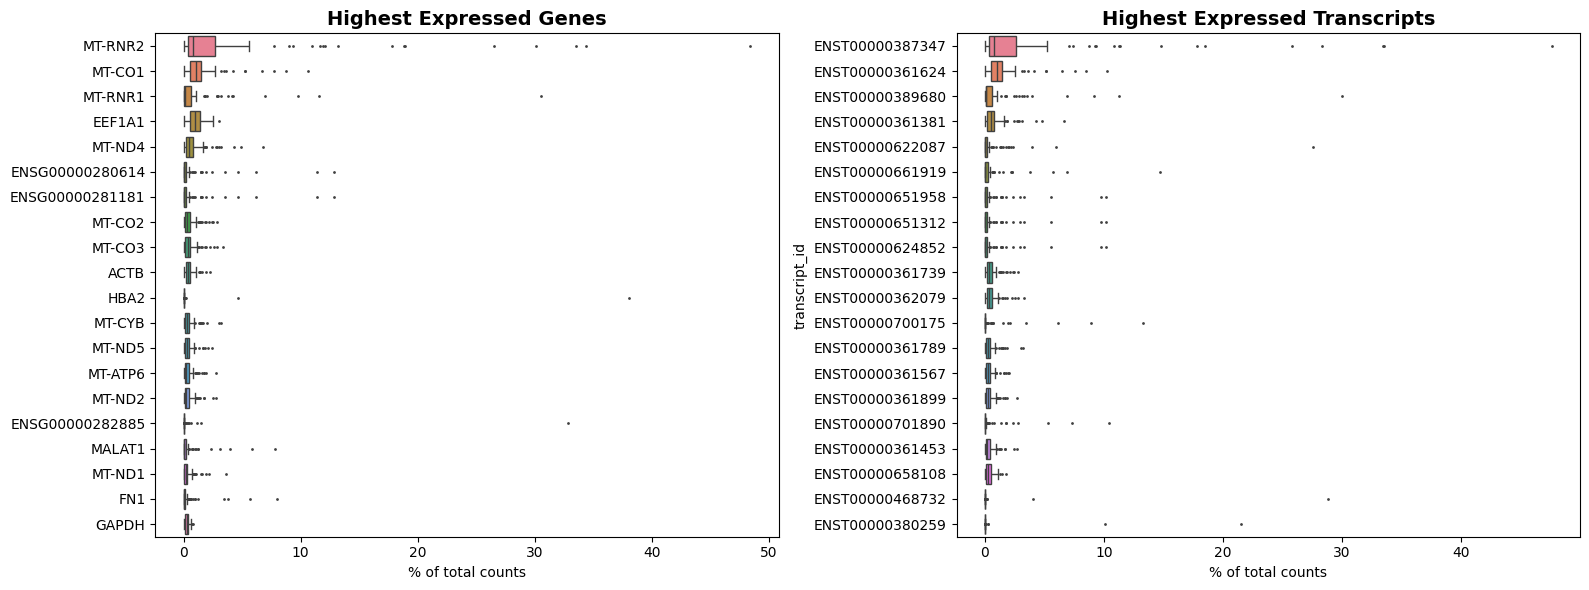


First few entries of the expression matrix:

Genes:
  (np.int32(0), np.int32(0))	42
  (np.int32(0), np.int32(1))	285
  (np.int32(0), np.int32(2))	17
  (np.int32(0), np.int32(4))	78
  (np.int32(1), np.int32(0))	1
  (np.int32(1), np.int32(1))	42
  (np.int32(1), np.int32(2))	4
  (np.int32(1), np.int32(4))	37
  (np.int32(2), np.int32(3))	1
  (np.int32(2), np.int32(0))	11
  (np.int32(2), np.int32(1))	61
  (np.int32(2), np.int32(2))	15
  (np.int32(2), np.int32(4))	28
  (np.int32(3), np.int32(1))	17
  (np.int32(3), np.int32(4))	21
  (np.int32(4), np.int32(0))	1
  (np.int32(4), np.int32(1))	231
  (np.int32(4), np.int32(4))	77

Transcripts:
  (np.int32(0), np.int32(0))	42
  (np.int32(0), np.int32(1))	285
  (np.int32(0), np.int32(2))	17
  (np.int32(0), np.int32(4))	57
  (np.int32(1), np.int32(0))	1
  (np.int32(1), np.int32(1))	42
  (np.int32(1), np.int32(2))	4
  (np.int32(1), np.int32(4))	29
  (np.int32(2), np.int32(0))	11
  (np.int32(2), np.int32(1))	61
  (np.int32(2), np.int32(2))	15
  (np.in

In [23]:
import scanpy as sc
import matplotlib.pyplot as plt

# Read the data
adata_genes = sc.read_h5ad('bulk_genes_subset.h5ad')
adata_transcripts = sc.read_h5ad('bulk_transcripts_subset.h5ad')

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot highest expressed genes in the first subplot
sc.pl.highest_expr_genes(adata_genes, n_top=20, ax=axes[0], show=False)
axes[0].set_title('Highest Expressed Genes', fontsize=14, fontweight='bold')

# Plot highest expressed transcripts in the second subplot
sc.pl.highest_expr_genes(adata_transcripts, n_top=20, ax=axes[1], show=False)
axes[1].set_title('Highest Expressed Transcripts', fontsize=14, fontweight='bold')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
# plt.savefig('highest_expressed_comparison.png', dpi=300, bbox_inches='tight')
# print("Figure saved as 'highest_expressed_comparison.png'")

# Show the plot
plt.show()

# Show first few entries of the expression matrix
print()
print("First few entries of the expression matrix:")
print("=" * 60)
print("\nGenes:")
print(adata_genes.X[:5, :5])
print("\nTranscripts:")
print(adata_transcripts.X[:5, :5])

**Disclaimer**: The highest expressed gene **IS NOT** neccesarily corresponding to the highest expressed transcript. <br>
However, it '*seems*' to be the case for the top 3 genes/ transcripts. 

**Converting into NumPy arrays:**

In [22]:
import numpy as np

X_genes = adata_genes.X.A if hasattr(adata_genes.X, "A") else adata_genes.X
Y_isoforms = adata_transcripts.X.A if hasattr(adata_transcripts.X, "A") else adata_transcripts.X

print("Original shapes:", X_genes.shape, Y_isoforms.shape)
print()
print("X stats - min:", X_genes.min(), "max:", X_genes.max(), "mean:", X_genes.mean())
print("Y stats - min:", Y_isoforms.min(), "max:", Y_isoforms.max(), "mean:", Y_isoforms.mean())


Original shapes: (100, 45263) (100, 162009)

X stats - min: 0 max: 30187200 mean: 822.700472571416
Y stats - min: 0 max: 30187200 mean: 240.28058811547507


**Pre-processing the data:**

In [23]:
# Log transform
X_genes_log = np.log1p(X_genes)
Y_isoforms_log = np.log1p(Y_isoforms)

# Standardize (z-score normalization)
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
X_genes_scaled = scaler_x.fit_transform(X_genes_log)

scaler_y = StandardScaler()
Y_isoforms_scaled = scaler_y.fit_transform(Y_isoforms_log)

print("\nAfter preprocessing:")
print("X stats - min:", X_genes_scaled.min(), "max:", X_genes_scaled.max(), "mean:", X_genes_scaled.mean())
print("Y stats - min:", Y_isoforms_scaled.min(), "max:", Y_isoforms_scaled.max(), "mean:", Y_isoforms_scaled.mean())

# Convert to PyTorch

import torch

X_genes_tensor = torch.tensor(X_genes_scaled, dtype=torch.float32)
Y_isoforms_tensor = torch.tensor(Y_isoforms_scaled, dtype=torch.float32)


# Train/test split

from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
    X_genes_tensor, Y_isoforms_tensor, test_size=0.2, random_state=42
)

print("\nSplit shapes:")
print("Train:", X_train.shape, Y_train.shape)
print("Test:", X_test.shape, Y_test.shape)




After preprocessing:
X stats - min: -6.8685441134452985 max: 9.94987437106624 mean: 2.8733787498294134e-17
Y stats - min: -6.6050371702065025 max: 9.949874371066244 mean: 1.782398310050088e-17

Split shapes:
Train: torch.Size([80, 45263]) torch.Size([80, 162009])
Test: torch.Size([20, 45263]) torch.Size([20, 162009])


**Pseudocount 1 log transforming the data:**

Mikkel's message on Slack: <br>
There are around 20,000 bulk samples and 180,000 single-cell samples in the datasets. The intention with the bulk data is to have a small dataset to develop your model on, where the problem is also easier, so you should be able to get good performance when the model has been implemented correctly.
Since the data is count data, a very common preprocessing step is to log-transform the data using a pseudocount of 1. A pseudocount is just a small number you add before log-transforming, the formula is essentially just log_count = log(count + 1). There are pytorch/numpy functions for doing this transformation called log1p.

Note to self: Later make a split for a **validation dataset** as well. 

**DataLoader:**

In [24]:
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train, Y_train)
test_ds = TensorDataset(X_test, Y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32)



**Setting the seed - for reproducibility of the randomized numbers:**

In [25]:
import torch
import numpy as np
import random

# Set seeds for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

**Setup architecture of a simple Linear Neural Network Model:**

In [26]:
import torch.nn as nn
import torch.optim as optim

class IsoformPredictor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.BatchNorm1d(1024),  # Add batch normalization. Stabilizes learning rate and prevents large gradient shifts. Normalizing layer inputs causes a more stable mean and variance across training steps.
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout for regularization. Drop 30% of the neurons randomly during training (decreases overfitting). 
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, output_dim)
            # NO final ReLU since data is already scaled/normalized
        )

    def forward(self, x):
        return self.net(x)

model = IsoformPredictor(X_train.shape[1], Y_train.shape[1])
optimizer = optim.Adam(model.parameters(), lr=1e-3)  # Increased learning rate


class WeightedMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        # Weight based on target magnitude
        # Higher expression = higher weight
        weights = torch.abs(target) + 1  # Add 1 to avoid zero weights
        weighted_errors = weights * (pred - target) ** 2
        return torch.mean(weighted_errors)

loss_fn = WeightedMSELoss()

Note: Amount of neurons might have to be adjusted to the full dataset, when trying on that. 

In [27]:
print("Model input dimensions:", X_train.shape[1], Y_train.shape[1])
#The expression level of 45263 genes (total mRNA) goes in --> expression level of 162009 isoforms goes out. 
#(Currently, we can't map the exact genes to its respective isoforms).

#I.e. we can run the expression matrix of 1 sample through the model at a time. 

Model input dimensions: 45263 162009


**Training the model:**

Epoch (1/30): Train Loss = 3.4148407777150473, Test Loss = 2.9881081581115723
Epoch (2/30): Train Loss = 3.012470563252767, Test Loss = 2.6437926292419434
Epoch (3/30): Train Loss = 2.6474648316701255, Test Loss = 2.735879421234131
Epoch (4/30): Train Loss = 2.4094577630360923, Test Loss = 2.7878904342651367
Epoch (5/30): Train Loss = 2.301530202229818, Test Loss = 2.6413869857788086
Epoch (6/30): Train Loss = 2.198542753855387, Test Loss = 2.4521241188049316
Epoch (7/30): Train Loss = 2.1002728939056396, Test Loss = 2.3364248275756836
Epoch (8/30): Train Loss = 2.01702614625295, Test Loss = 2.2957005500793457
Epoch (9/30): Train Loss = 1.9315017064412434, Test Loss = 2.28332781791687
Epoch (10/30): Train Loss = 1.9216222763061523, Test Loss = 2.2725753784179688
Epoch (11/30): Train Loss = 1.8694913784662883, Test Loss = 2.26515531539917
Epoch (12/30): Train Loss = 1.8752726316452026, Test Loss = 2.2605113983154297
Epoch (13/30): Train Loss = 1.8144450982411702, Test Loss = 2.252214670

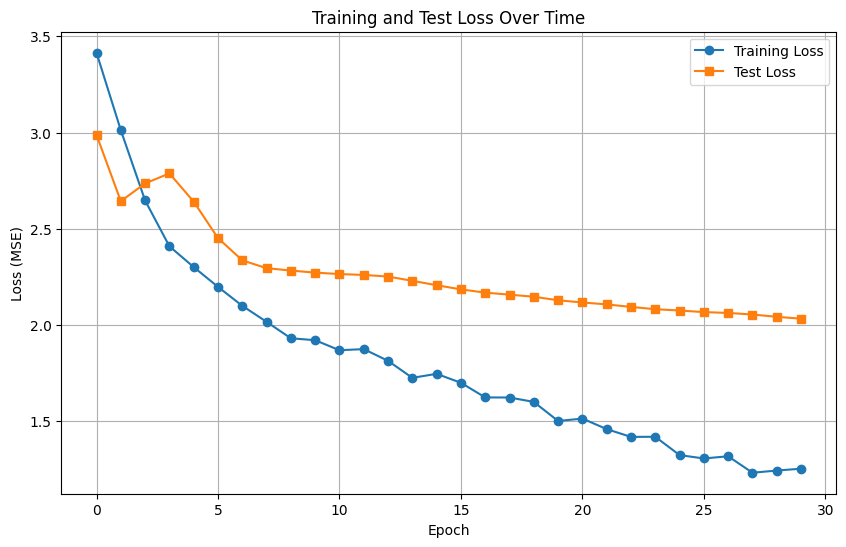

In [28]:
import matplotlib.pyplot as plt

N_epochs = 30 #More than epochs may be needed when scaling up to the full dataset. 
train_losses = []
test_losses = []

for epoch in range(N_epochs):
    # Training
    model.train()
    total_train_loss = 0
    for xb, yb in train_dl:
        optimizer.zero_grad()       #For each batch, we need to zero the gradients. PyTorch accumulates gradients by default... which can be a bit annoying in most cases. 
        preds = model(xb)           #Using the model to predict the transcript expression from gene expression. 
        loss = loss_fn(preds, yb)   #mean squared error, as defined above. 
        loss.backward()             #Backpropagate. I.e., gradients are computed to determine how much each weight affected the loss. 
        optimizer.step()            #Subsequently, the weights are adjusted using these gradients.
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_dl)
    train_losses.append(avg_train_loss)
    
    # Evaluate on test set after each epoch
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for xb, yb in test_dl:
            preds = model(xb)
            loss = loss_fn(preds, yb)
            total_test_loss += loss.item()
    
    avg_test_loss = total_test_loss / len(test_dl)
    test_losses.append(avg_test_loss)
    
    print(f"Epoch ({epoch+1}/{N_epochs}): Train Loss = {avg_train_loss}, Test Loss = {avg_test_loss}")

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', marker='o')
plt.plot(test_losses, label='Test Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Test Loss Over Time')
plt.legend()
plt.grid(True)
plt.show()


**Evaluating model performance:**

In [29]:
model.eval()
with torch.no_grad():
    preds = torch.cat([model(xb) for xb, _ in test_dl])
    y_true = torch.cat([yb for _, yb in test_dl])
    mse = torch.mean((preds - y_true)**2)
print("Test MSE:", mse.item())

Test MSE: 0.7858438491821289


Scatter plot: Predictions vs Actual values (test set)

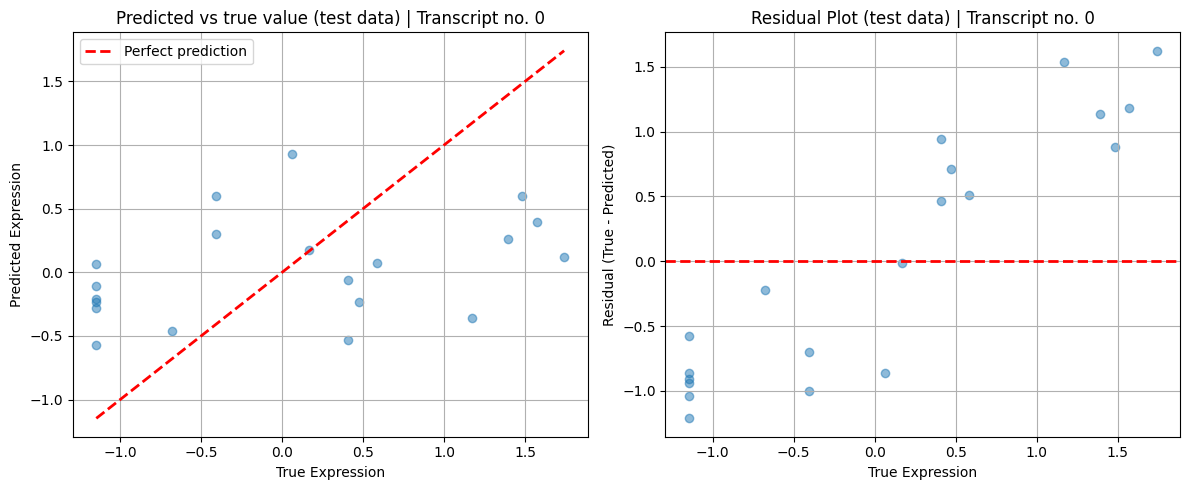

In [30]:
import matplotlib.pyplot as plt
import numpy as np

model.eval()
with torch.no_grad():
    preds = torch.cat([model(xb) for xb, _ in test_dl])
    y_true = torch.cat([yb for _, yb in test_dl])

# Convert to numpy for plotting
preds_np = preds.cpu().numpy()
y_true_np = y_true.cpu().numpy()

# Scatter plot: Predicted vs Actual (for first transcript as example)
transcript_idx = 0  # Choose which transcript to visualize

plt.figure(figsize=(12, 5))

# Plot 1: Scatter plot for one transcript
plt.subplot(1, 2, 1)
plt.scatter(y_true_np[:, transcript_idx], preds_np[:, transcript_idx], alpha=0.5)
plt.plot([y_true_np[:, transcript_idx].min(), y_true_np[:, transcript_idx].max()], 
         [y_true_np[:, transcript_idx].min(), y_true_np[:, transcript_idx].max()], 
         'r--', lw=2, label='Perfect prediction')
plt.xlabel('True Expression')
plt.ylabel('Predicted Expression')
plt.title(f'Predicted vs true value (test data) | Transcript no. {transcript_idx}')
plt.legend()
plt.grid(True)

# Plot 2: Residuals (errors)
plt.subplot(1, 2, 2)
residuals = y_true_np[:, transcript_idx] - preds_np[:, transcript_idx]
plt.scatter(y_true_np[:, transcript_idx], residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--', lw=2)
plt.xlabel('True Expression')
plt.ylabel('Residual (True - Predicted)')
plt.title(f'Residual Plot (test data) | Transcript no. {transcript_idx}')
plt.grid(True)

plt.tight_layout()
plt.show()


Note: The data has gone through various log transformations and normalizations. This is why the expression levels can be negative. 

TEST SET PERFORMANCE
Overall Mean Squared Error (MSE): 0.7858
Overall Mean Absolute Error (MAE): 0.6773
Overall R² Score: -20674369656483.4883


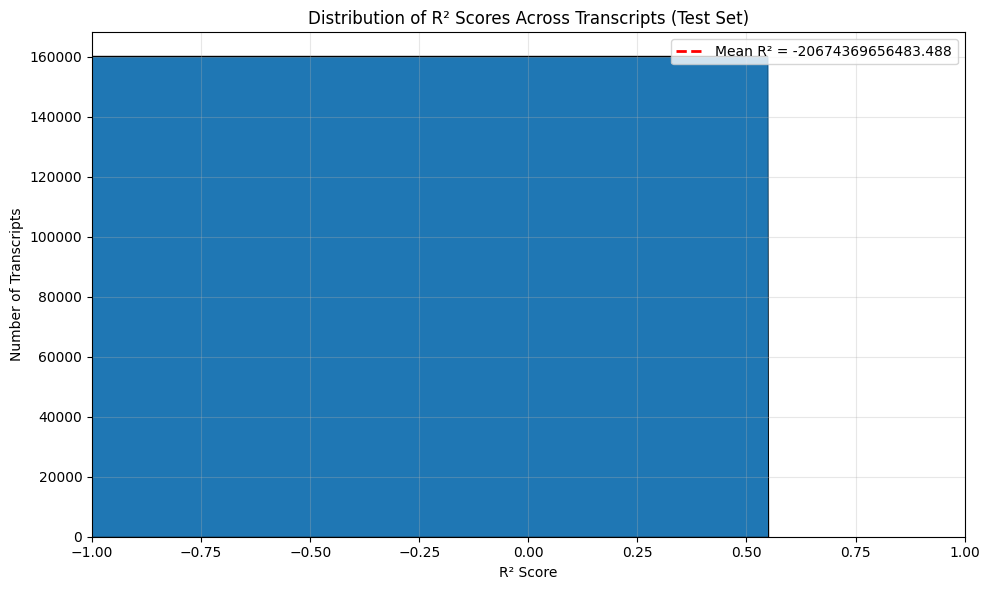

In [31]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

model.eval()
with torch.no_grad():
    preds = torch.cat([model(xb) for xb, _ in test_dl])
    y_true = torch.cat([yb for _, yb in test_dl])

preds_np = preds.cpu().numpy()
y_true_np = y_true.cpu().numpy()

# Calculate metrics for each transcript
n_transcripts = y_true_np.shape[1]
mse_per_transcript = []
mae_per_transcript = []
r2_per_transcript = []

for i in range(n_transcripts):
    mse = mean_squared_error(y_true_np[:, i], preds_np[:, i])
    mae = mean_absolute_error(y_true_np[:, i], preds_np[:, i])
    r2 = r2_score(y_true_np[:, i], preds_np[:, i])
    
    mse_per_transcript.append(mse)
    mae_per_transcript.append(mae)
    r2_per_transcript.append(r2)

# Overall metrics on test set
print("=" * 50)
print("TEST SET PERFORMANCE")
print("=" * 50)
print(f"Overall Mean Squared Error (MSE): {np.mean(mse_per_transcript):.4f}")
print(f"Overall Mean Absolute Error (MAE): {np.mean(mae_per_transcript):.4f}")
print(f"Overall R² Score: {np.mean(r2_per_transcript):.4f}")
print("=" * 50)

# Plot distribution of R² scores across transcripts
plt.figure(figsize=(10, 6))
plt.hist(r2_per_transcript, bins=50, edgecolor='black')
plt.xlabel('R² Score')
plt.ylabel('Number of Transcripts')
plt.title('Distribution of R² Scores Across Transcripts (Test Set)')
plt.axvline(np.mean(r2_per_transcript), color='red', linestyle='--', 
            linewidth=2, label=f'Mean R² = {np.mean(r2_per_transcript):.3f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-1, 1) #IMPORTANT NOTE: We just restrict it to -1 to 1, but there are also values much, much lower than -1. 
plt.tight_layout()
plt.show()


Run time: 3 minutes and 1 second. 

In [32]:
# Get predictions on both train and test sets
model.eval()
with torch.no_grad():
    train_preds = torch.cat([model(xb) for xb, _ in train_dl])
    train_true = torch.cat([yb for _, yb in train_dl])
    test_preds = torch.cat([model(xb) for xb, _ in test_dl])
    test_true = torch.cat([yb for _, yb in test_dl])

train_mse = torch.mean((train_preds - train_true)**2).item()
test_mse = torch.mean((test_preds - test_true)**2).item()

print("\n" + "=" * 50)
print("FINAL MODEL PERFORMANCE")
print("=" * 50)
print(f"Training mean squared error (MSE):   {train_mse}")
print(f"Test mean squared error (MSE):       {test_mse}")
print(f"Overfitting:    {test_mse - train_mse} (lower is better)")
print("=" * 50)


FINAL MODEL PERFORMANCE
Training mean squared error (MSE):   1.5876290798187256
Test mean squared error (MSE):       0.7858438491821289
Overfitting:    -0.8017852306365967 (lower is better)
